This notebook looks at using R for fitting linear models.

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev1 toc-item"><a href="#Descriptives-by-age-and-gender" data-toc-modified-id="Descriptives-by-age-and-gender-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Descriptives by age and gender</a></div><div class="lev1 toc-item"><a href="#Modeling-pageviews" data-toc-modified-id="Modeling-pageviews-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling pageviews</a></div><div class="lev2 toc-item"><a href="#Views-by-age,-linear-features" data-toc-modified-id="Views-by-age,-linear-features-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Views by age, linear features</a></div><div class="lev2 toc-item"><a href="#Views-by-age,-quadratic-features" data-toc-modified-id="Views-by-age,-quadratic-features-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Views by age, quadratic features</a></div><div class="lev2 toc-item"><a href="#Views-by-age-and-gender,-no-interactions" data-toc-modified-id="Views-by-age-and-gender,-no-interactions-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Views by age and gender, no interactions</a></div><div class="lev2 toc-item"><a href="#Views-by-age-and-gender,-with-interactions" data-toc-modified-id="Views-by-age-and-gender,-with-interactions-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Views by age and gender, with interactions</a></div>

# Setup

First we'll load some packages, including the recent `modelr` for easy modeling, setting options to warn us whenever observations with missing values are ignored by our models.

In [3]:
library(tidyverse)
library(scales)

library(modelr)
options(na.action = na.warn)

theme_set(theme_bw())
options(repr.plot.width=4, repr.plot.height=3)

Now we'll read in a file containing containing information on 225,000 anonymous Nielsen panelists, containing their age, gender, and the number of pages (~distinct urls) they typically access on their web browser each day.

In [4]:
users <- read_tsv(gzfile('users.tsv.gz'))
head(users)

age,gender,daily.views
55,Female,163.4
19,Male,226.0
33,Female,54.1
38,Male,51.2
65,Female,39.9
20,Female,27.1


Let's take a quick look at the distribution of daily pageviews, which we'll plot on log scale.

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 102 rows containing non-finite values (stat_bin).”

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 102 rows containing non-finite values (stat_bin).”

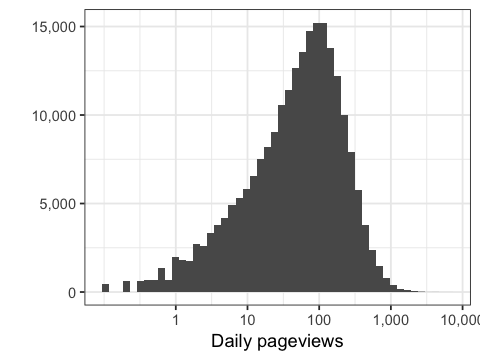

In [5]:
# histogram of the label/regressor variable:
ggplot(users, aes(x = daily.views)) +
  geom_histogram(bins = 50) +
  scale_x_log10(label=comma, breaks=10^(0:ceiling(log10(max(users$daily.views))))) +
  scale_y_continuous(label = comma) +
  xlab('Daily pageviews') +
  ylab('')
ggsave(filename='figures/daily_pageviews_dist.pdf', width=4, height=4)

Most people view around 100 pages per day, with a few accounts showing several thousand while others have almost done. These extremes are probably instrumentation or logging errors.

Notice the warning about the infinite values. These are people with zero daily views, who we'll filter out later.

# Descriptives by age and gender

Next a few simple plots to see how activity varies by age and gender.

One idea is to plot every user as one point, located by their age and daily pageviews, splitting by gender.

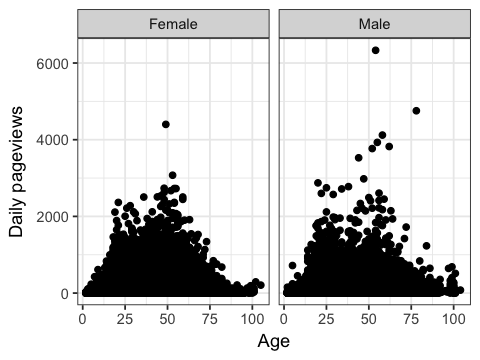

In [6]:
ggplot(data = users, aes(x = age, y = daily.views)) +
  geom_point() +
  facet_wrap(~ gender) +
  xlab('Age') +
  ylab('Daily pageviews')
ggsave(filename='figures/daily_pageviews_by_age_and_gender.pdf', width=8, height=4)

This shows us a bit about the data, but there are two problems: first, there are too many points on the plot, and second the extremes dominate the scale.

Let's filter out the ~100 users with no views and then count median views by age and gender to summarize the data. The median will mitigate the skew from the extremes and give us an idea of the "typical" user at any age and gender.

In [7]:
nrow(users)
users <- filter(users, daily.views > 0)
nrow(users)

[1] 226847

[1] 226745

In [8]:
views_by_age_and_gender <- users %>%
  filter(age <= 90) %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            median_daily_views = median(daily.views))
head(views_by_age_and_gender)

age,gender,count,median_daily_views
2,Female,29,2.80
2,Male,30,4.85
3,Female,86,4.05
3,Male,90,4.10
4,Female,195,4.20
4,Male,187,5.00


Let's plot these results to get an idea of any trends in the data.

We'll use point size to indicate the number of users at each age and gender.

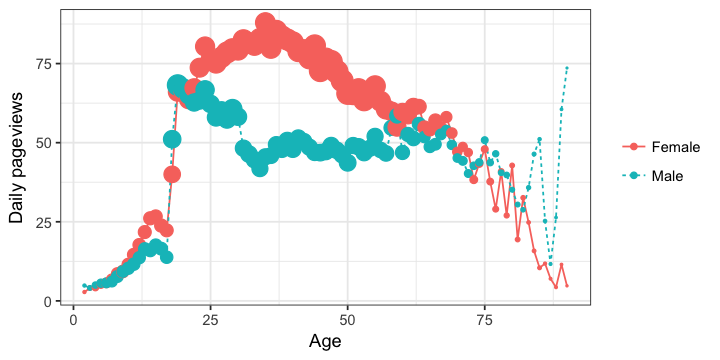

In [9]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(views_by_age_and_gender, aes(x = age, y = median_daily_views, color = gender)) +
  geom_line(aes(linetype=gender)) +
  geom_point(aes(size = count)) +
  xlab('Age') + 
  ylab('Daily pageviews') +
  scale_size_area(guide = F) +
  theme(legend.title=element_blank())
ggsave(filename='figures/median_daily_pageviews_by_age_and_gender.pdf', width=8, height=4)

Now we see a few clear trends.

First, data is fairly sparse under 18 years of 18, and then seems to suddenly jump up. Likewise, there isn't much data for people over 65. Finally, it looks like men generate fewer views than women, and viewing habits change differently with age for men and women.

# Modeling pageviews

Let's models to smooth out some of the noise in the descriptives and pull out clearer trends. We'll focus on people between 18 and 65, where most of the data are.

In [10]:
model_data <- filter(users, age >= 18 & age <= 65)

## Views by age, linear features

We'll start by just using `geom_smooth` with a linear model to show an overall age trend.

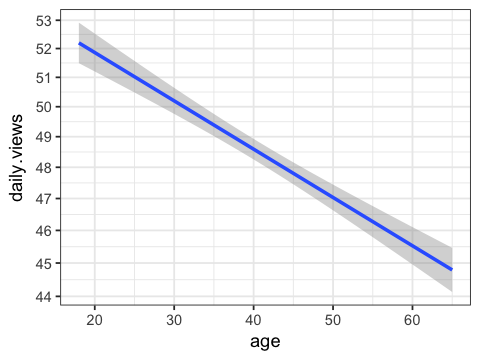

In [11]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(model_data, aes(x = age, y = daily.views)) +
  geom_smooth(method = "lm") +
  scale_y_log10(breaks = 1:100)

This shows the simple trend that pageviews go down with age, on average.

Now, instead of having `ggplot2` do the modeling for us, let's do it ourselves using `lm`.

Informed by our earlier plots, we'll work in log space, and specify a simple formula for the model.

In [12]:
model <- lm(log10(daily.views) ~ age, model_data)
model
# see summary(model) for more information, including standard errors and p-values for these estimates


Call:
lm(formula = log10(daily.views) ~ age, data = model_data)

Coefficients:
(Intercept)          age  
   1.743111    -0.001414  


Behind the scenes, R has used our formula to convert the `model_data` data frame to a matrix of features and solves the normal equations. Here's a look at what was created.

In [13]:
M <- model.matrix(log10(daily.views) ~ age, model_data)
head(M)

,(Intercept),age
1,1,55
2,1,19
3,1,33
4,1,38
5,1,65
6,1,20


Notice that a constant feature has been added to incorporate an intercept in the model. This will get more interesting as we change the structure of the model below.

Next we'll plot the model's predictions, transforming things back from log space. This is often much easier than staring at a table of cofficient estimates.

First, we need to get predictions out of the model. The old way to do this was to create a new data frame with the values to make predictions from and then call the `predict` or `fitted` functions from base R, but this is a bit ugly.

In [14]:
plot_data <- model_data %>%
  distinct(age)
plot_data$predicted <- 10^predict(model, plot_data)
head(plot_data)

age,predicted
55,46.27342
19,52.02858
33,49.70996
38,48.90717
65,44.79090
20,51.85943


The `modelr` package provides cleaner syntax for doing this, along with some helper functions.

`data_grid` takes all combinations of all of the unique values in each column provided to it (here just a list of every age), and `add_predictions` adds the predicted values.

The result is equivalent to the above, with the rows in different order.

In [15]:
plot_data <- model_data %>%
  data_grid(age) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)
head(plot_data)

age,pred
18,52.19827
19,52.02858
20,51.85943
21,51.69084
22,51.52279
23,51.35529


Finally, we can make our own version of the `geom_smooth` plot above.

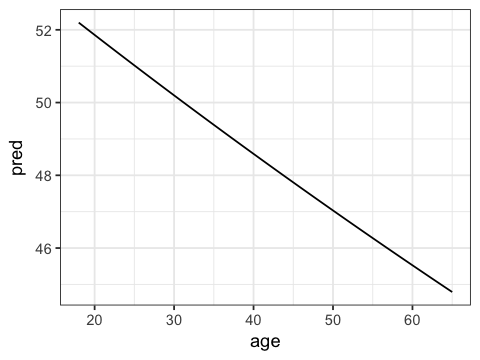

In [16]:
ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line()

This is somewhat useful, but it's always nice to have the actual data to compare against the model.

We can add this using yet a third way of generating plot data, this time by summarizing the model data and computing the (geometric) mean of the daily views for each age and then adding predictions.

The geometric mean is just the average in log space, which is exactly what the model is trying to capture.

In [17]:
plot_data <- model_data %>%
  group_by(age) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)
head(plot_data)

age,count,geom_mean_daily_views,pred
18,3512,35.22038,52.19827
19,4765,47.23623,52.02858
20,4426,48.17692,51.85943
21,3864,47.62008,51.69084
22,3880,48.15020,51.52279
23,3975,49.47335,51.35529


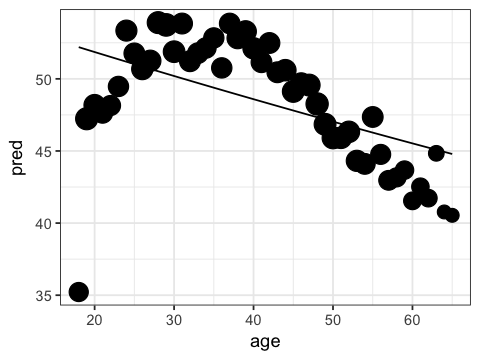

In [18]:
ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)

From this it's clear that our simple linear model is missing some important trends: viewing rises in the 20s and 30s, and then declines.

## Views by age, quadratic features

Luckily we can capture this non-linear pattern with a linear model. This might sound surprising, but the "linear" in the model refers to the fact that the model is linear in the weights, not the features.

So we can continue to use `lm`, but just add a non-linear feature, the square of a person's age. This will let us fit a parabola instead of a line. In R syntax we just "add" this feature to the model with the appropriate formula syntax.

In [19]:
model <- lm(log10(daily.views) ~ age + I(age^2), model_data)
model



Call:
lm(formula = log10(daily.views) ~ age + I(age^2), data = model_data)

Coefficients:
(Intercept)          age     I(age^2)  
  1.5062581    0.0116702   -0.0001619  


Again, we can look at the model matrix that was created behind the scenes, which is now more interesting and contains another column.

In [20]:
M <- model.matrix(log10(daily.views) ~ age + I(age^2), model_data)
head(M)

,(Intercept),age,I(age^2)
1,1,55,3025
2,1,19,361
3,1,33,1089
4,1,38,1444
5,1,65,4225
6,1,20,400


And we can plot the new model against the data, to see that there's a much better fit.

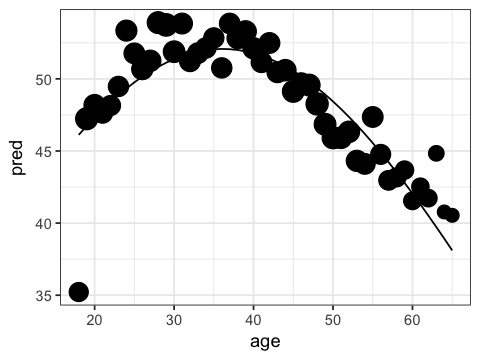

In [21]:
plot_data <- model_data %>%
  group_by(age) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

ggplot(plot_data, aes(x = age, y = pred)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)

## Views by age and gender, no interactions

Now, following our descriptive plot above, let's add gender to the model.

The simplest way we could do this is to add a fixed offset for gender.

In [22]:
form <- as.formula(log10(daily.views) ~ gender + age + I(age^2))
M <- model.matrix(form, model_data)
model <- lm(form, model_data)
head(M)
model

,(Intercept),genderMale,age,I(age^2)
1,1,0,55,3025
2,1,1,19,361
3,1,0,33,1089
4,1,1,38,1444
5,1,0,65,4225
6,1,0,20,400



Call:
lm(formula = form, data = model_data)

Coefficients:
(Intercept)   genderMale          age     I(age^2)  
  1.6424078   -0.1638158    0.0082615   -0.0001246  


Notice what's happened here. R recognized that `gender` was a factor and added a column for it.

Specifically, it took the first level of the factor (`female`), and made it the default, and then added a column called `genderMale` which is 0 for men and 1 for women. The result is that the intercept implicitly incorporates information about female viewing habits.

Again, it's difficult to get the full picture from the coefficients table, so let's plot the results.

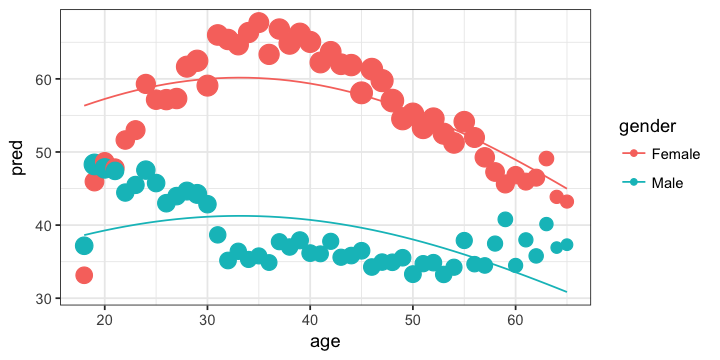

In [23]:
options(repr.plot.width=6, repr.plot.height=3)
plot_data <- model_data %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

ggplot(plot_data, aes(x = age, y = pred, color = gender)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)

The plot makes clear a failing of the model: simply "adding" gender to the model doesn't capture the fact that women's activity goes up and then down with age, while men's goes down and then up.

## Views by age and gender, with interactions

What we've failed to capture is that we want a different parabola by gender, meaning we'd like different coefficients for the `age` and `age^2` terms for men and women. This is referred to as an "interaction".

Here's one way to specify this in an R formula. (See [here](http://bit.ly/2m0gWH8) for more on formula syntax.)

In [24]:
form <- as.formula(log10(daily.views) ~ gender * (age + I(age^2)))
M <- model.matrix(form, model_data)
model <- lm(form, model_data)
head(M)
model

,(Intercept),genderMale,age,I(age^2),genderMale:age,genderMale:I(age^2)
1,1,0,55,3025,0,0
2,1,1,19,361,19,361
3,1,0,33,1089,0,0
4,1,1,38,1444,38,1444
5,1,0,65,4225,0,0
6,1,0,20,400,0,0



Call:
lm(formula = form, data = model_data)

Coefficients:
        (Intercept)           genderMale                  age             I(age^2)       genderMale:age  genderMale:I(age^2)  
          1.3111470            0.5702782            0.0253549           -0.0003252           -0.0386190            0.0004570  


Again, looking at the model matrix and the table of coefficients shows that R has done a lot of work to create new features.

In addition to the columns we had before, now we have columns for `genderMale:age` and `genderMale:I(age^2)`. These last two columns are zero for females, and age or its square for males. This results in a different parabola by gender.

It gets increasingly difficult to interpret the fitted coefficients as we add more and more interactions to our models, so let's plot the results one last time.

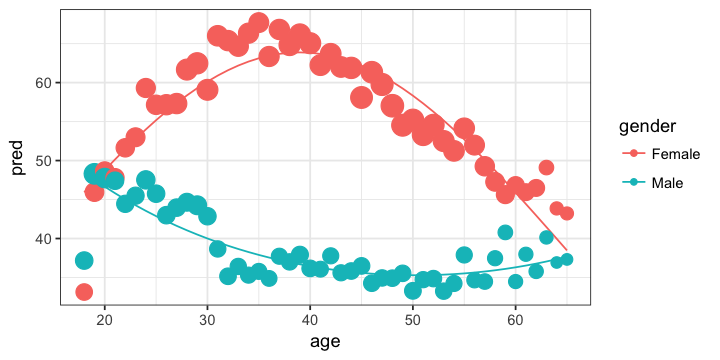

In [25]:
plot_data <- model_data %>%
  group_by(age, gender) %>%
  summarize(count = n(),
            geom_mean_daily_views = 10^(mean(log10(daily.views)))) %>%
  add_predictions(model) %>%
  mutate(pred = 10^pred)

options(repr.plot.width=6, repr.plot.height=3)
ggplot(plot_data, aes(x = age, y = pred, color = gender)) +
  geom_line(aes(y = pred)) +
  geom_point(aes(y = geom_mean_daily_views, size = count)) +
  scale_size_area(guide = F)
ggsave(filename='figures/modeled_daily_pageviews_by_age_and_gender.pdf', width=8, height=4)

Finally we have a model that captures most of the regularities in our data, while glossing over the noise.